In [1]:
import pandas as pd
import dateutil.parser
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as patches

from matplotlib.dates import DateFormatter
from scipy.ndimage import gaussian_filter, zoom
from datetime import timedelta, datetime

billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100["week"] = billboard_hot_100["first_day_of_the_week"].dt.week
billboard_hot_100.head()

C:\Users\cutie\AppData\Local\Temp\ipykernel_21388\523238995.py:20: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  billboard_hot_100["week"] = billboard_hot_100["first_day_of_the_week"].dt.week


,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year,week
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958,37
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958,37
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958,37
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958,37
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958,37


In [2]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

plt.rcParams.update({'font.size': 15})

### Analysis of top artists in decades (most position 1 songs)

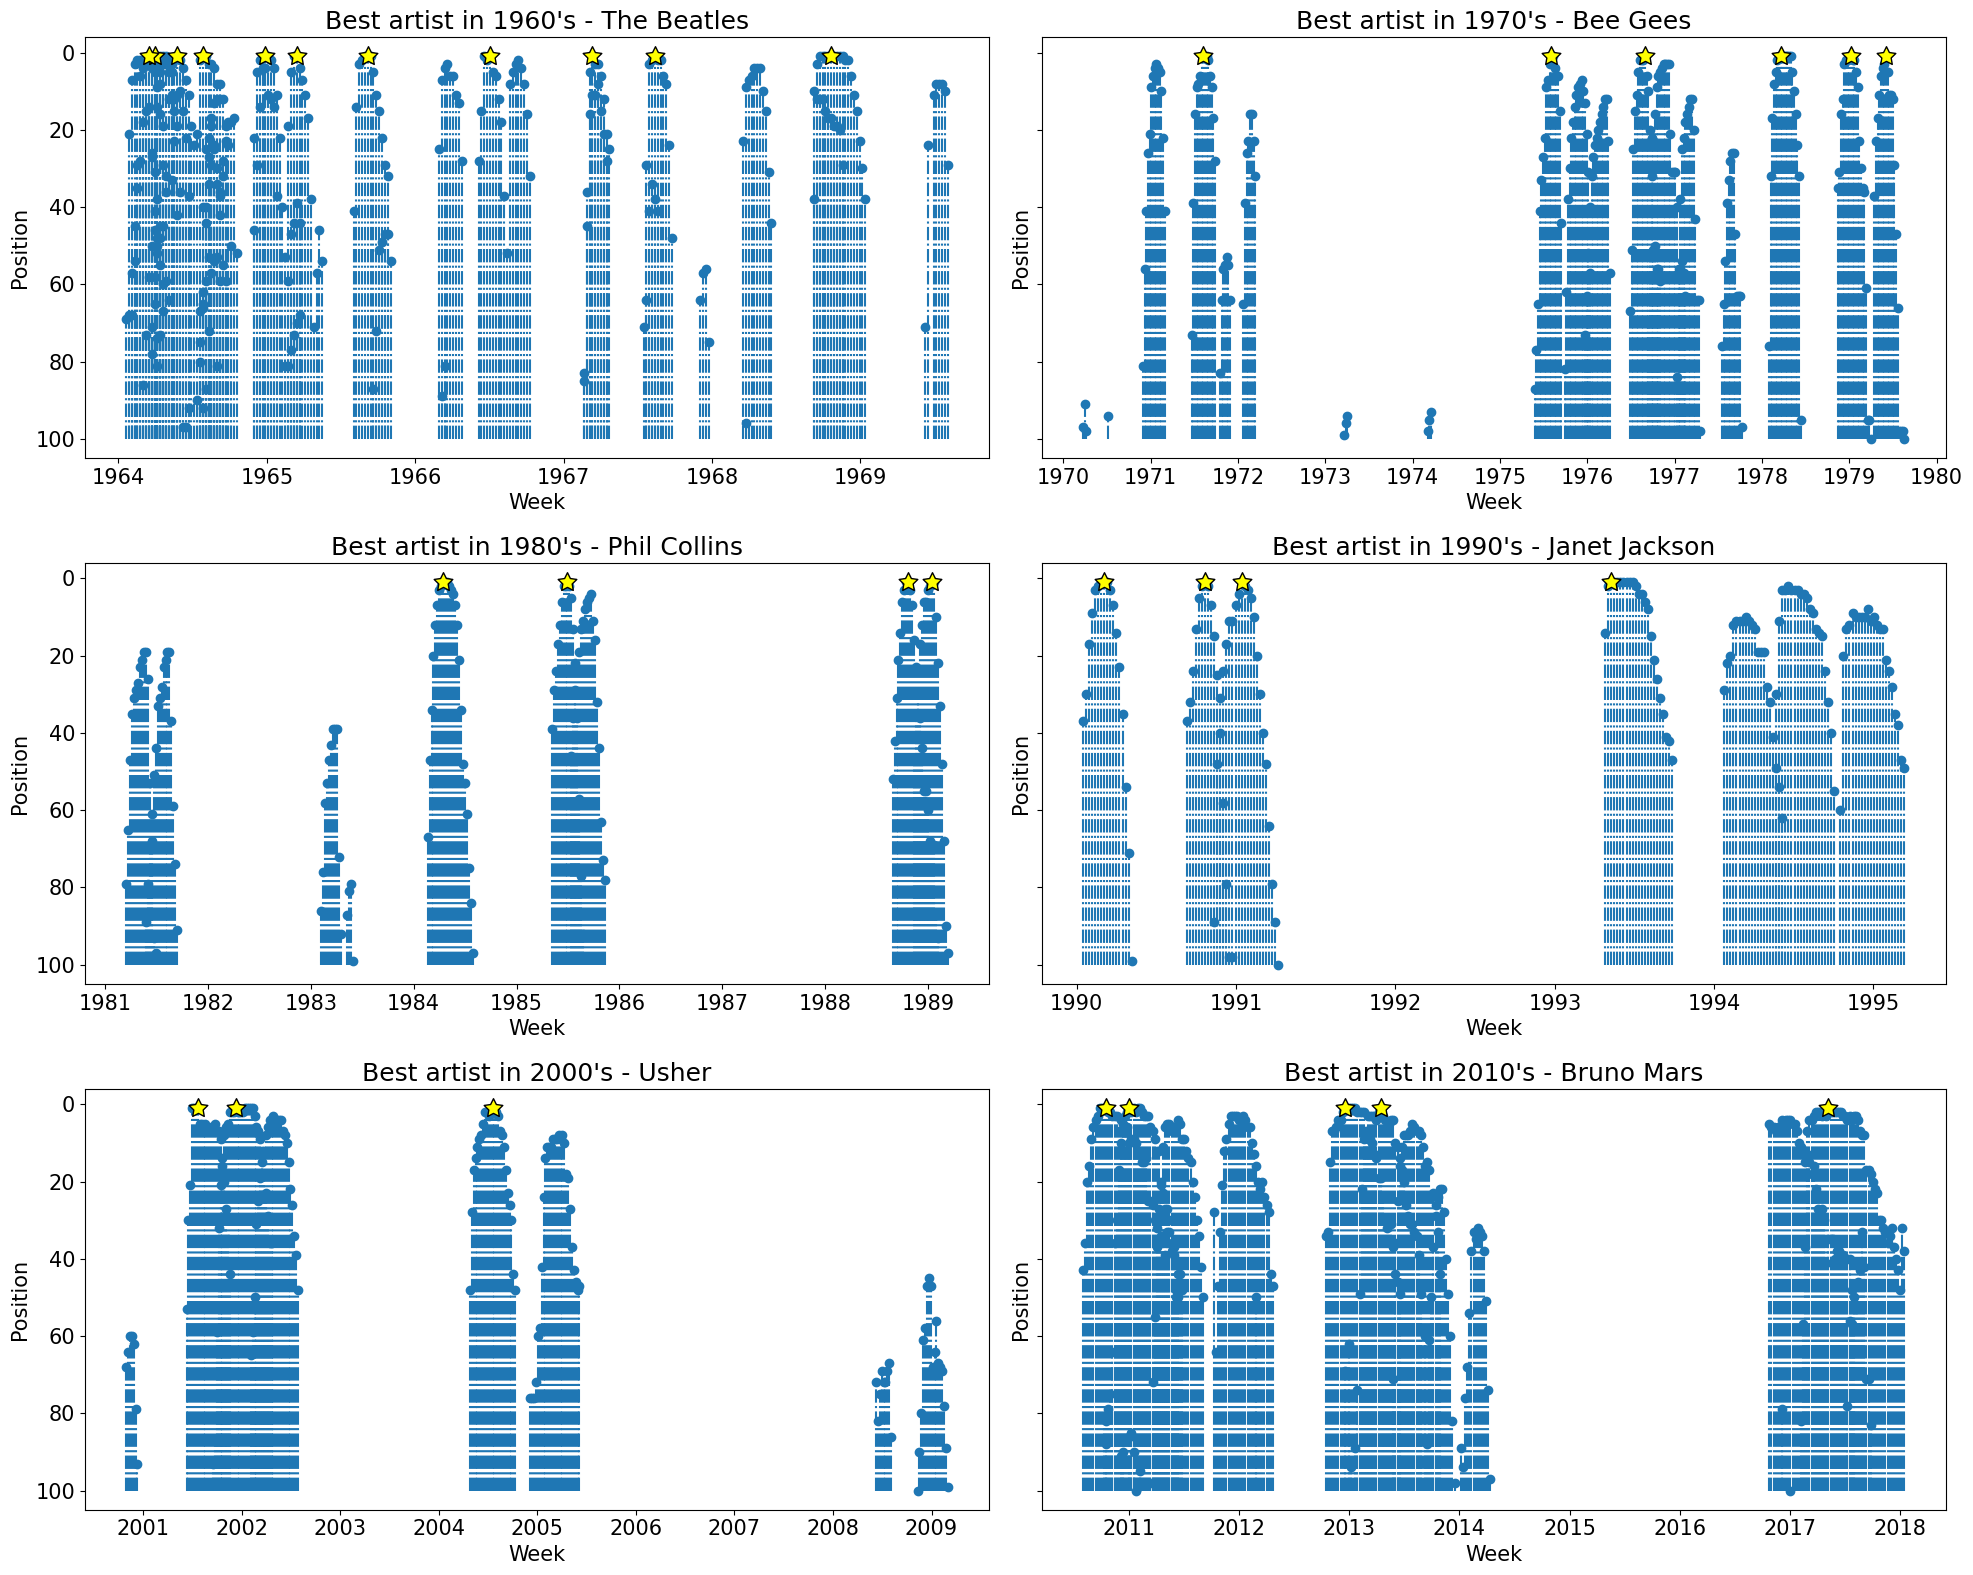

In [56]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "first_day_of_the_week", "position"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # take songs only from this decade that have never been in top 10
    all_songs_in_decade = all_songs_in_decade[~(all_songs_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            all_songs_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))].copy()

    # calculate the number of unique songs for each artist in the decade (which were number one)
    songs_per_artist = all_songs_in_decade[all_songs_in_decade["position"] == 1].groupby("artist")["song_name"].nunique().reset_index().sort_values(
        "song_name", ascending=False)

    best_artist_from_decade = songs_per_artist.head(1)

    all_songs_from_best_artist = all_songs_in_decade[all_songs_in_decade["artist"].isin(best_artist_from_decade["artist"])]

    position_ones = all_songs_from_best_artist[all_songs_from_best_artist["position"] == 1].groupby("song_name").first().reset_index()
    axes[row_i, col_i].scatter(position_ones["first_day_of_the_week"], position_ones["position"], color="yellow", s=200, edgecolor='black', marker=(5, 1), zorder=10)
    markerline, stemlines, baseline = axes[row_i, col_i].stem(all_songs_from_best_artist["first_day_of_the_week"], all_songs_from_best_artist["position"], bottom=100, basefmt=" ",
        linefmt="-.")

    # setting property of baseline with color red and linewidth 2 https://stackoverflow.com/questions/13145218/stem-plot-in-matplotlib
    plt.setp(baseline, alpha=0.4, linewidth=0.5)

    axes[row_i, col_i].set_title(f"Best artist in {year}'s - {best_artist_from_decade['artist'].values[0]}")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

plt.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/decades_career_analysis.pdf", format="pdf")
plt.show()


### Analysis of top artists in decades (most songs in the charts)

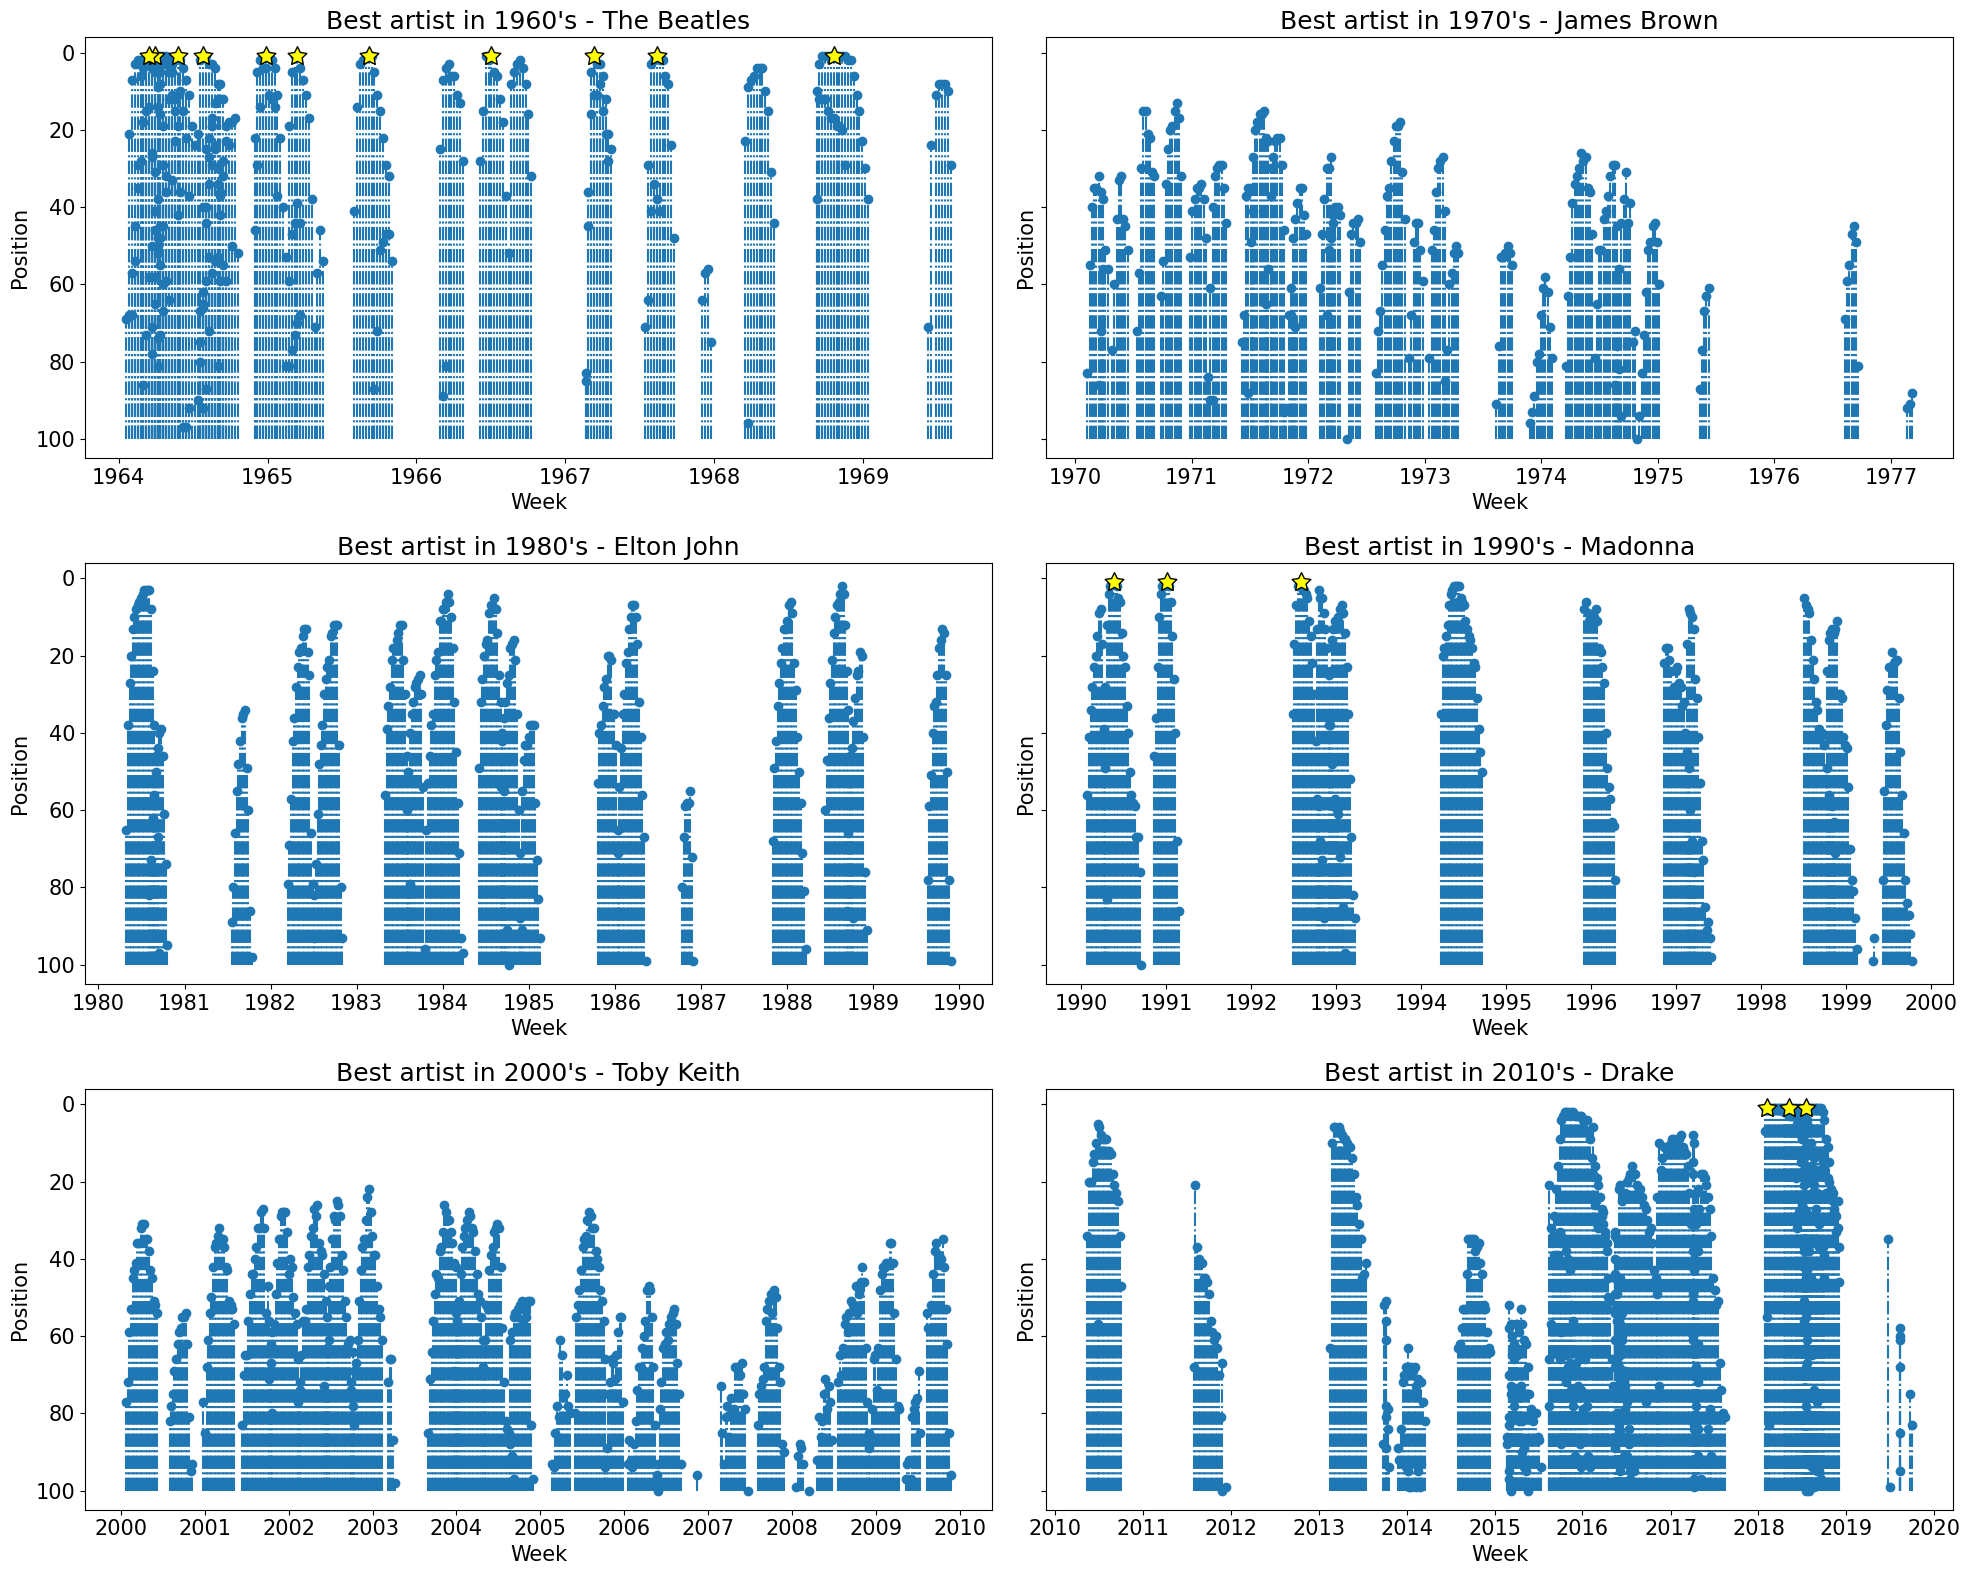

In [57]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10)][["artist", "song_name", "first_day_of_the_week", "position"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # take songs only from this decade that have never been in top 10
    all_songs_in_decade = all_songs_in_decade[~(all_songs_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            all_songs_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))].copy()

    # calculate the number of unique songs for each artist in the decade
    songs_per_artist = all_songs_in_decade.groupby("artist")["song_name"].nunique().reset_index().sort_values(
        "song_name", ascending=False)

    best_artist_from_decade = songs_per_artist.head(1)

    all_songs_from_best_artist = all_songs_in_decade[all_songs_in_decade["artist"].isin(best_artist_from_decade["artist"])]

    position_ones = all_songs_from_best_artist[all_songs_from_best_artist["position"] == 1].groupby("song_name").first().reset_index()
    axes[row_i, col_i].scatter(position_ones["first_day_of_the_week"], position_ones["position"], color="yellow", s=200, edgecolor='black', marker=(5, 1), zorder=10)
    markerline, stemlines, baseline = axes[row_i, col_i].stem(all_songs_from_best_artist["first_day_of_the_week"], all_songs_from_best_artist["position"], bottom=100, basefmt=" ",
        linefmt="-.")

    # setting property of baseline with color red and linewidth 2 https://stackoverflow.com/questions/13145218/stem-plot-in-matplotlib
    plt.setp(baseline, alpha=0.4, linewidth=0.5)

    axes[row_i, col_i].set_title(f"Best artist in {year}'s - {best_artist_from_decade['artist'].values[0]}")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

plt.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/decades_career_analysis_most_songs.pdf", format="pdf")
plt.show()